<a href="https://colab.research.google.com/github/xAn-x/Language-Modelling-Zero-to-One/blob/master/03_RNNs_for_Language_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,Subset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-07-12 14:11:06--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2024-07-12 14:11:07 (110 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
with open('input.txt','r',encoding='utf-8') as f:
  text=f.read()

In [214]:
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [169]:
class TinyShakespeare(Dataset):
  def __init__(self,text_corpus,block_size):
    super().__init__()

    self.text_corpus=text
    self.block_size=block_size

    self.vocab=sorted(list(set(text)))
    self.vocab_size=len(self.vocab)

    self.stoi={ch:i for i,ch in enumerate(self.vocab)}
    self.itos={i:ch for i,ch in enumerate(self.vocab)}

    encoded_text=torch.tensor(self.encode(text))

    X,Y=[],[]
    n=len(text_corpus)
    for i in range(n-block_size):
      x=encoded_text[i:i+block_size]
      y=encoded_text[i+block_size]

      X.append(x)
      Y.append(y)

    self.inp=torch.stack(X)
    self.out=torch.tensor(Y)



  def encode(self,sentences:str | list[str]) -> list[int]:
    if isinstance(sentences,str):
      sentences=[sentences]

    encoded_lst=[]
    for sentence in sentences:
      encoded_lst.append([self.stoi[ch] for ch in sentence])

    return encoded_lst[0] if len(encoded_lst)==1 else encoded_lst



  def decode(self,encoded_lst: list[list[int]]) -> list[str]:
    decoded_lst=[]
    for lst in encoded_lst:
      decoded_str="".join([self.itos[num] for num in lst])
      decoded_lst.append(decoded_str)

    return decoded_lst[0] if len(decoded_lst)==1 else decoded_lst


  def __getitem__(self,idx):
    return self.inp[idx],self.out[idx]


  def __len__(self):
    return self.inp.shape[0]


In [170]:
block_size=8
batch_size=64

In [171]:
ds=TinyShakespeare(text,block_size)

In [172]:
ds[:5]

(tensor([[18, 47, 56, 57, 58,  1, 15, 47],
         [47, 56, 57, 58,  1, 15, 47, 58],
         [56, 57, 58,  1, 15, 47, 58, 47],
         [57, 58,  1, 15, 47, 58, 47, 64],
         [58,  1, 15, 47, 58, 47, 64, 43]]),
 tensor([58, 47, 64, 43, 52]))

In [215]:
X,y=ds[:15]
X=X.tolist()

ds.decode(X)

['First Ci',
 'irst Cit',
 'rst Citi',
 'st Citiz',
 't Citize',
 ' Citizen',
 'Citizen:',
 'itizen:\n',
 'tizen:\nB',
 'izen:\nBe',
 'zen:\nBef',
 'en:\nBefo',
 'n:\nBefor',
 ':\nBefore',
 '\nBefore ']

In [216]:
len(ds)

1115386

In [217]:
ds.vocab_size

65

In [218]:
train_size = int(0.85 * len(ds))
val_size = len(ds) - train_size

train_ds = Subset(ds, range(0, train_size))
val_ds = Subset(ds, range(train_size, len(ds)))

print(f'Length of train-ds: {len(train_ds)}')
print(f'Length of val-ds: {len(val_ds)}')

Length of train-ds: 948078
Length of val-ds: 167308


In [222]:
X,y=val_ds[:25]
X,y

(tensor([[43,  6,  0, 13, 57,  1, 21,  6],
         [ 6,  0, 13, 57,  1, 21,  6,  1],
         [ 0, 13, 57,  1, 21,  6,  1, 58],
         [13, 57,  1, 21,  6,  1, 58, 46],
         [57,  1, 21,  6,  1, 58, 46, 59],
         [ 1, 21,  6,  1, 58, 46, 59, 57],
         [21,  6,  1, 58, 46, 59, 57,  1],
         [ 6,  1, 58, 46, 59, 57,  1, 61],
         [ 1, 58, 46, 59, 57,  1, 61, 56],
         [58, 46, 59, 57,  1, 61, 56, 53],
         [46, 59, 57,  1, 61, 56, 53, 52],
         [59, 57,  1, 61, 56, 53, 52, 45],
         [57,  1, 61, 56, 53, 52, 45,  5],
         [ 1, 61, 56, 53, 52, 45,  5, 42],
         [61, 56, 53, 52, 45,  5, 42,  6],
         [56, 53, 52, 45,  5, 42,  6,  1],
         [53, 52, 45,  5, 42,  6,  1, 46],
         [52, 45,  5, 42,  6,  1, 46, 43],
         [45,  5, 42,  6,  1, 46, 43, 52],
         [ 5, 42,  6,  1, 46, 43, 52, 41],
         [42,  6,  1, 46, 43, 52, 41, 43],
         [ 6,  1, 46, 43, 52, 41, 43,  1],
         [ 1, 46, 43, 52, 41, 43,  1, 59],
         [4

In [223]:
X=X.tolist()
ds.decode(X)

['e,\nAs I,',
 ',\nAs I, ',
 '\nAs I, t',
 'As I, th',
 's I, thu',
 ' I, thus',
 'I, thus ',
 ', thus w',
 ' thus wr',
 'thus wro',
 'hus wron',
 'us wrong',
 "s wrong'",
 " wrong'd",
 "wrong'd,",
 "rong'd, ",
 "ong'd, h",
 "ng'd, he",
 "g'd, hen",
 "'d, henc",
 'd, hence',
 ', hence ',
 ' hence u',
 'hence un',
 'ence unb']

In [226]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=batch_size*2,shuffle=False,num_workers=2,pin_memory=True)

In [227]:
len(train_dl),len(val_dl)

(14814, 1308)

In [276]:
class RnnTinyShakespear(nn.Module):
  def __init__(self,block_size,embedding_dim,vocab_size,rnn_hidden=100,num_layers=3):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.rnn=nn.LSTM(embedding_dim,rnn_hidden,num_layers,batch_first=True,dropout=0.2,bidirectional=False)
    self.linear=nn.Linear(rnn_hidden*block_size,vocab_size)

  def forward(self,x):
    out=self.embedding(x)
    # print(f"Embedding:{x.shape}")
    out,(hidden,cell)=self.rnn(out)
    # print(f"out:{out.shape}")
    # print(f"hidden:{hidden.shape}")
    # print(f"cell:{cell.shape}")
    out=out.contiguous().view(x.size(0),-1)
    out=self.linear(out)
    # print(f"out:{out.shape}")
    return out


In [277]:
model=RnnTinyShakespear(block_size,15,ds.vocab_size)
model

RnnTinyShakespear(
  (embedding): Embedding(65, 15)
  (rnn): LSTM(15, 100, num_layers=3, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=800, out_features=65, bias=True)
)

In [278]:
for x,y in train_dl:
  print(f"X:{x.shape}")
  print(f"y:{y.shape}")
  out=model(x)
  break

X:torch.Size([64, 8])
y:torch.Size([64])


In [279]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [280]:
model=model.to(device)

In [281]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [282]:
from tqdm import tqdm

def fit(model, opt, epochs, train_dl, val_dl, scheduler=None):
  history = {"loss": [], "val_loss": []}
  criterion = nn.CrossEntropyLoss()

  if scheduler is not None:
      assert isinstance(scheduler, (StepLR, ReduceLROnPlateau)), "Scheduler must be an instance of StepLR or ReduceLROnPlateau"

  for epoch in range(epochs):
      model.train()
      train_loss = 0.0
      for xb, yb in tqdm(train_dl, desc=f"Training Epoch {epoch+1}/{epochs}"):
          xb, yb = xb.to(device), yb.to(device)

          opt.zero_grad()
          preds = model(xb)
          loss = criterion(preds.view(-1, preds.size(-1)), yb.view(-1))  # Calculate loss
          loss.backward()
          opt.step()

          train_loss += loss.item() * xb.size(0)  # Accumulate loss

      train_loss /= len(train_dl.dataset)
      history["loss"].append(train_loss)

      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for xb, yb in tqdm(val_dl, desc=f"Validation Epoch {epoch+1}/{epochs}"):
              xb, yb = xb.to(device), yb.to(device)

              preds = model(xb)
              loss = criterion(preds.view(-1, preds.size(-1)), yb.view(-1))  # Calculate loss

              val_loss += loss.item() * xb.size(0)  # Accumulate loss

      val_loss /= len(val_dl.dataset)
      history["val_loss"].append(val_loss)

      if scheduler is not None:
          if isinstance(scheduler, StepLR):
              scheduler.step()
          elif isinstance(scheduler, ReduceLROnPlateau):
              scheduler.step(val_loss)

      print(f"\n\nEpoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n\n")

  return history

In [296]:
@torch.no_grad()
def generate(n_chars=500, temperature=1.0):
    model.eval()
    ix = torch.randint(len(text), (1,)).item()
    inp = ds.encode(text[ix:ix+block_size])
    out = [ds.decode([inp])]

    for i in range(n_chars):
        input_batch = torch.tensor(inp).unsqueeze(0).to(device)
        logits = model(input_batch)

        # Apply temperature scaling to logits for sampling diversity
        logits /= temperature
        probs = F.softmax(logits, dim=-1)

        # Sample from the distribution
        predicted_idx = torch.multinomial(probs, num_samples=1).squeeze().tolist()

        decoded_ch = ds.decode([[predicted_idx]])
        out.append(decoded_ch)

        inp = inp[1:] + [predicted_idx]
        print(decoded_ch, end='')

    return "".join(out)

In [284]:
# Without Training
print(generate(500)) # as Model is equally likely to predict any character

X!adLANghxN
; D-LRSl&umqnJHoXBnWja
XWkmjX;LLrWjj: OebjeVlClMnhCf UPjYKnWZugk!DTEHbeJ!'!WlD$'sVYJibbD;qgqPNnxd.l.c.u;cVh&zPfuxHs, dBG3kiAqePUyygWbdUUuhksG.qG?QhP3Gg
fDDUuPuyuXBZvrMan3cyGjikvj3k-pqO,IW!-v:l L ytiQTu&3Qx-HTscP:h-V-$$.''sKgH RMVObEnEKIaGa3R;Bt eoL,Y$,PbxBoOy;GKTLY'S'IbWn,Zc
l&cQ33a$LgqE&QuVNFXrM,n3V;ystby'SJThYD!LwocBVBtd,;sRhmP?eD.JOrNoNnGNpgNQbYHb'B&ITFCGDW,AWgn;YY!rWy
.B$jRFSGT;acP.VP,RKGykFBoRXdpIl Zz jIKmdjLiidtToYVQ?mQnkLpD-,ylSSUnMriRMgMBSpAr-WK&oNe?!ikqqZSJyjSg3!FjTbMYzNj-THX!adLANghxN
; D-LRSl&umqnJHoXBnWja
XWkmjX;LLrWjj: OebjeVlClMnhCf UPjYKnWZugk!DTEHbeJ!'!WlD$'sVYJibbD;qgqPNnxd.l.c.u;cVh&zPfuxHs, dBG3kiAqePUyygWbdUUuhksG.qG?QhP3Gg
fDDUuPuyuXBZvrMan3cyGjikvj3k-pqO,IW!-v:l L ytiQTu&3Qx-HTscP:h-V-$$.''sKgH RMVObEnEKIaGa3R;Bt eoL,Y$,PbxBoOy;GKTLY'S'IbWn,Zc
l&cQ33a$LgqE&QuVNFXrM,n3V;ystby'SJThYD!LwocBVBtd,;sRhmP?eD.JOrNoNnGNpgNQbYHb'B&ITFCGDW,AWgn;YY!rWy
.B$jRFSGT;acP.VP,RKGykFBoRXdpIl Zz jIKmdjLiidtToYVQ?mQnkLpD-,ylSSUnMriRMgMBSpAr-WK&oNe?!ikqqZSJyjSg3!FjTbMYzNj-TH

In [290]:
# Since Every char is equally likely to be predicted initial loss
init_loss=-torch.log(1/ds.vocab_size)

TypeError: log(): argument 'input' (position 1) must be Tensor, not float

In [285]:
history = fit(model, optimizer, 7, train_dl, val_dl,scheduler)

Validation Epoch 1/7: 100%|██████████| 1308/1308 [00:04<00:00, 267.07it/s]




Epoch 1/7, Train Loss: 2.2202, Val Loss: 2.0401




Validation Epoch 2/7: 100%|██████████| 1308/1308 [00:04<00:00, 307.80it/s]




Epoch 2/7, Train Loss: 1.8155, Val Loss: 1.9114




Validation Epoch 3/7: 100%|██████████| 1308/1308 [00:07<00:00, 167.75it/s]




Epoch 3/7, Train Loss: 1.6954, Val Loss: 1.8497




Validation Epoch 4/7: 100%|██████████| 1308/1308 [00:04<00:00, 270.24it/s]




Epoch 4/7, Train Loss: 1.6285, Val Loss: 1.8182




Validation Epoch 5/7: 100%|██████████| 1308/1308 [00:04<00:00, 317.07it/s]




Epoch 5/7, Train Loss: 1.5844, Val Loss: 1.7987




Validation Epoch 6/7: 100%|██████████| 1308/1308 [00:04<00:00, 317.34it/s]




Epoch 6/7, Train Loss: 1.5767, Val Loss: 1.7621




Validation Epoch 7/7: 100%|██████████| 1308/1308 [00:04<00:00, 322.96it/s]



Epoch 7/7, Train Loss: 1.5583, Val Loss: 1.7586




In [286]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Saved Models/rnn_language_model.pth")

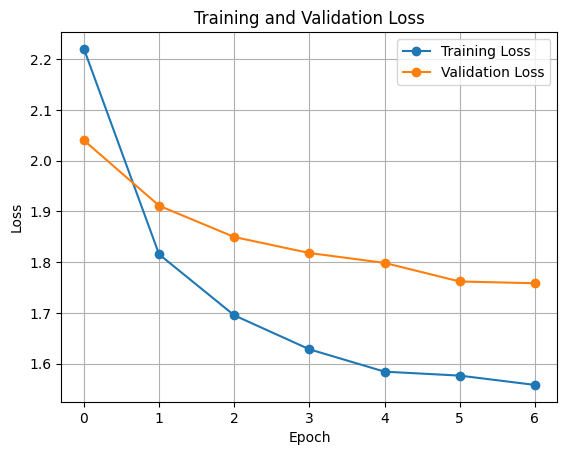

In [287]:
def plot_loss(history):
    plt.plot(history['loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [298]:
print(generate(500))

 behiid; sweet, and him.

POMPEY:
I know for thee; succesces,
And from this keed you as it tell you wake him therefore but, but and to her
Go so rupy somet
Who boy the provaltary heart hy will knot the give to look he to mine
Hath prace.

CYOp Lester conscipent than he may came steap intending of me
Far.

ISABELLA:
When every nicher.

FROTUZ:
Looky not.

DUKE VINCENTIO:
That can
Well from this sif, thriek draw,
And should reqsbees from thus, retirate you, and wixed bitturely from his:
Ay. Why, bho finds behiid; sweet, and him.

POMPEY:
I know for thee; succesces,
And from this keed you as it tell you wake him therefore but, but and to her
Go so rupy somet
Who boy the provaltary heart hy will knot the give to look he to mine
Hath prace.

CYOp Lester conscipent than he may came steap intending of me
Far.

ISABELLA:
When every nicher.

FROTUZ:
Looky not.

DUKE VINCENTIO:
That can
Well from this sif, thriek draw,
And should reqsbees from thus, retirate you, and wixed bitturely from his:
Ay

In [289]:
# Done